# Introduction

# 📊 **Financial Article Sentiment and Emotion Analysis**

In this notebook, we dive into a comprehensive analysis of **financial articles** from **Yahoo Finance**, with a focus on extracting insights from **sentiments, emotions, and entities** within the articles. Our multi-step approach combines **Natural Language Processing (NLP)** and **time-series stock data** to reveal trends and correlations between market sentiment and stock performance.

---

### 🛠️ **1. Imports**

We begin by importing libraries for **data manipulation**, **NLP**, and **sentiment analysis**. These include tools for web scraping, advanced text analysis, and data visualization to streamline each stage of analysis.

---

### 📥 **2. Data Loading**

We load our primary dataset of financial articles and corresponding **stock data** in CSV format. This combination of article content and stock performance will enable us to analyze sentiment alongside market trends.

---

### 🧹 **3. Data Cleaning and Preprocessing**

Data preparation steps include:

- 🔄 **Deduplication** and **missing value handling** for cleaner analysis.
- 🧽 **Text preprocessing** by removing URLs, symbols, and stop words.
- 📅 **Standardizing dates** to UTC format for time-series analysis consistency.

---

### 🤖 **4. Sentiment Analysis**

To capture sentiment at multiple levels, we apply various NLP models:

- **VADER** for quick polarity scoring.
- **FinBERT**, a finance-specific model, for deeper sentiment analysis across sentences and articles.
- 📊 Aggregating results by article using sum, mean, max, and weighted metrics for comprehensive sentiment insights.

---

### 💼 **5. Entity Recognition**

We use **SpaCy** to extract key entities like companies, products, and locations from each article, enriching our sentiment analysis with context and relevance to specific topics.

---

### 💬 **6. Emotion Extraction by Sentence**

By applying **NRC Lexicon**, we break down each article into sentence-level emotions, capturing a nuanced view of emotional expression. We aggregate emotions across articles using sum, mean, and max metrics, as well as a **weighted mean** to emphasize intense emotions, revealing patterns in emotional tone.

---

### ⏳ **7. Stock Data Integration**

Using **yfinance**, we retrieve hourly stock data for selected companies from **January 1, 2024**, aligning it with article publication times for correlation analysis. The data is stored in UTC to ensure compatibility with the article dataset.

---

### 📊 **8. Data Overview and Monthly Article Count Visualization**

In this step, we’ll display a stacked bar chart showing the monthly article count for each company, giving us a quick view of data distribution over time. All other visualizations, including interactive sentiment and emotion trends, are part of a dedicated dashboard linked at the end of this project.

---
### 📚 **9. Next Steps**

As we progress, this comprehensive DataFrame will serve as a foundation for more in-depth analyses, including potential correlations between sentiment trends and market performance. The insights gained will guide future explorations and applications in financial sentiment analysis.

Additionally, the dedicated dashboard will provide an interactive platform for visualizing sentiment and emotional trends, enhancing our ability to interpret data effectively.

# Imports & Initial Setup

This section imports essential libraries and modules for data processing, sentiment analysis, and visualization. It also includes setup commands, such as downloading necessary NLTK resources.

### Library Imports

In this subsection, we import libraries for web scraping, data manipulation, and natural language processing. These libraries are key for loading, processing, and analyzing the text data.

In [ ]:
# ! pip install pandas numpy matplotlib nltk textblob nrclex bertopic sentence_transformers transformers bertopic

In [1]:
import requests
from bs4 import BeautifulSoup
import urllib.parse
import time
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
from transformers import pipeline
import spacy
from nrclex import NRCLex
from bertopic import BERTopic
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
from utils import *
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px

### NLTK Setup

This step ensures that required NLTK resources, such as stopwords and sentiment lexicons, are available for text processing and sentiment analysis.

In [2]:
# Download necessary NLTK data resources
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')  # for sentence tokenization
nltk.download('vader_lexicon')  # for sentiment analysis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arie8\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arie8\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\arie8\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\arie8\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Data Loading and Initial Cleaning

In this section, we load article data for the top S&P 500 companies from JSON files, organized by month, and store each company's data in a dictionary. Next, we preprocess the data by converting dates to a standard format, removing duplicates, and adding temporal features.

In [ ]:
dfs = {}
year = 2024

for company in SP_TOP:
    tmp_df = pd.DataFrame()
    for month in range(1, 11):
        path = f'./articles/{company}/{year}/{month}_articles.json'
        tmp_df = pd.concat([tmp_df, pd.read_json(path)], ignore_index=True)
    
    tmp_df.reset_index(drop=True, inplace=True)
    dfs[company] = tmp_df

In [ ]:
import pandas as pd

for key in dfs.keys():
    # Convert the date column to datetime
    dfs[key]['Date'] = pd.to_datetime(dfs[key]['Date'])
    
    # Sort the DataFrame by the 'Date' column
    dfs[key] = dfs[key].sort_values(by='Date')
    print(f'Shape before removing duplicates from {key}: ' + str(dfs[key].shape))
    
    # Remove duplicate rows based on 'Title' and 'Date'
    dfs[key] = dfs[key].drop_duplicates(subset=['Title', 'Date'])
    dfs[key].dropna(inplace=True)
    
    # Optionally, reset the index if you want a clean index after dropping duplicates
    dfs[key].reset_index(drop=True, inplace=True)
    
    print(f'Shape after removing duplicates from {key}: ' + str(dfs[key].shape))
    
    # Extract month for grouping
    dfs[key]['Month'] = dfs[key]['Date'].dt.to_period('M')
    dfs[key]['Week'] = dfs[key]['Date'].dt.to_period('W')
    dfs[key]['Company'] = key

In [ ]:
df = pd.concat(dfs, ignore_index=True)
df.info()

### Text Cleaning

This section defines and applies a text-cleaning function to remove unwanted elements like URLs, special characters, and excess whitespace. The cleaned text is saved in a new column for further analysis.

In [ ]:
# Function to clean text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\\S+|www\\S+|https\\S+', ' ', text, flags=re.MULTILINE)
    # Remove mentions and hashtags
    text = re.sub(r'\\@\\w+|\\#', ' ', text)
    # Remove special characters and numbers, but keep spaces
    text = re.sub(r'[^A-Za-z\\s]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces but keep single spaces
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

# Apply cleaning
df['clean_content_context'] = df['Text'].apply(clean_text)

# Display the first few rows of the cleaned dataset
df.head()


### Text Tokenization

To prepare for sentence-level analysis, we tokenize each article's text into sentences and store these in a new column for use in further sentiment analysis and topic modeling.

In [ ]:
from nltk.tokenize import sent_tokenize

# Tokenize the text into sentences
df['text_sentences'] = df['Text'].apply(sent_tokenize)

# Print the title of the first article
print(df.iloc[0]['Title'])

# Display the sentences of the first article
df.iloc[0]['text_sentences']

### Data Summary

Finally, we display the overall shape of the DataFrame and the first few rows to verify data readiness before proceeding to analysis and visualization.

In [10]:
print(df.shape)
df.head()

(10932, 10)


,Unnamed: 0,Date,Title,Author,Text,Month,Week,Company,clean_content_context,text_sentences
0,0,2024-01-02 10:05:00+00:00,Better Growth Stock in 2024: Amazon vs. Apple,"Dani Cook, The Motley Fool","The new year is here, and there are plenty of ...",2024-01,2024-01-01/2024-01-07,Apple,the new year is here and there are plenty of ...,"['The new year is here, and there are plenty o..."
1,1,2024-05-20 05:29:10+00:00,Solana Wallet Phantom Surges to Third Place on...,Hope C,"Phantom Wallet, a popular cryptocurrency walle...",2024-05,2024-05-20/2024-05-26,Apple,phantom wallet a popular cryptocurrency walle...,"['Phantom Wallet, a popular cryptocurrency wal..."
2,2,2024-08-14 08:57:11+00:00,Apple supplier Foxconn's profit beats forecast...,Yimou Lee and Faith Hung,By Yimou Lee and Faith Hung\nTAIPEI (Reuters) ...,2024-08,2024-08-12/2024-08-18,Apple,by yimou lee and faith hung taipei reuters ...,['By Yimou Lee and Faith Hung TAIPEI (Reuters)...
3,3,2024-01-03 14:42:51+00:00,1 Artificial Intelligence (AI) Stock Poised to...,"Parkev Tatevosian, CFA, The Motley Fool",Fool.com contributor Parkev Tatevosian highlig...,2024-01,2024-01-01/2024-01-07,Microsoft,fool com contributor parkev tatevosian highlig...,['Fool.com contributor Parkev Tatevosian highl...
4,4,2024-07-01 20:38:25+00:00,"Ballmer Is Richer Than Gates, a First for Micr...",Vernal Galpotthawela,(Bloomberg) -- Steve Ballmer passed Bill Gates...,2024-07,2024-07-01/2024-07-07,Microsoft,bloomberg steve ballmer passed bill gates ...,['(Bloomberg) -- Steve Ballmer passed Bill Gat...


### Sentence Embedding and Filtering with Similarity

This section demonstrates how to leverage sentence embeddings and similarity metrics to filter sentences based on their relevance to a core sentence, using a pre-trained transformer model. This approach helps in selecting sentences that align closely with the core topic of the article.

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained sentence transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Define a core sentence related to the article
core_sentence = "Microsoft's stock has performed strongly over the last five years."

# Encode the core sentence
core_embedding = model.encode(core_sentence)

# Your article sentences (assuming df['text_sentences'] contains the sentences)
sentences = df.iloc[0]['text_sentences']

# Filter sentences based on similarity to the core sentence
filtered_sentences = []
for sentence in sentences:
    sentence_embedding = model.encode(sentence)
    similarity = util.pytorch_cos_sim(core_embedding, sentence_embedding)

    # If similarity is above a certain threshold, keep the sentence
    if similarity.item() > 0.2:  # Adjust threshold as necessary
        filtered_sentences.append(sentence)

# Output the filtered sentences as a single string
filtered_output = ' '.join(filtered_sentences)
filtered_output


### Checking for Long Sentences

This section provides a function to split sentences that exceed the model’s maximum input length of 512 tokens into smaller chunks. This is useful for processing lengthy sentences without truncating them, maintaining the context and continuity.

In [ ]:
# Function to check for sentences longer than 512 characters
def check_long_sentences(sentences):
    return sum(len(sentence) > 512 for sentence in sentences)

# Create a new column indicating whether any sentence exceeds 512 characters
long_sentence_count = df['text_sentences'].apply(check_long_sentences).sum()

# Output the total count of long sentences
long_sentence_count

In [ ]:
max_words = 512

def split_long_sentences(sentences, max_chars=512):
    new_sentences = []

    for sentence in sentences:
        words = sentence.split()
        current_chunk = []
        current_length = 0
        
        for word in words:
            word_length = len(word) + 1  # +1 for the space or delimiter
            if word_length > max_words:
                word = ''
            # Check if adding this word exceeds the max_chars limit
            if current_length + word_length <= max_chars:
                current_chunk.append(word)
                current_length += word_length
            else:
                # If the chunk is full, append it to new_sentences and start a new chunk
                new_sentences.append(' '.join(current_chunk))
                current_chunk = [word]
                current_length = word_length  # reset the length for the new chunk
        
        # Append the last chunk if there are remaining words
        if current_chunk:
            new_sentences.append(' '.join(current_chunk))

    return new_sentences

# Apply the function to the text_sentences column
df['text_sentences'] = df['text_sentences'].apply(split_long_sentences)

# Create a new column indicating whether any sentence exceeds 512 characters
long_sentence_count = df['text_sentences'].apply(check_long_sentences).sum()

# Output the total count of long sentences
long_sentence_count

# Sentiment Analysis Section

In this section, we apply various sentiment analysis techniques to our dataset to extract different types of sentiment information, including general sentiment, emotions, and finance-specific sentiment. This analysis will provide insights into the overall tone, emotions, and subjectivity in our news articles.

### General Sentiment Analysis


We start by performing general sentiment analysis using the VADER (Valence Aware Dictionary and sEntiment Reasoner) model from NLTK, which is specifically designed to analyze sentiments in social media text. VADER provides a compound score representing overall sentiment (positive, neutral, or negative).

In [ ]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize Sentiment Intensity Analyzer (VADER) for sentiment analysis
sia = SentimentIntensityAnalyzer()

# Apply VADER's polarity_scores function to each text in the 'Text' column of the DataFrame
# This returns a dictionary of sentiment scores for each text (compound, positive, neutral, negative)
vader = df['Text'].apply(sia.polarity_scores)

# Convert the list of dictionaries containing sentiment scores into a DataFrame
vader_sentiment_df = pd.DataFrame(vader.tolist())

# Display the first few rows of the resulting DataFrame to inspect the sentiment scores
vader_sentiment_df.head()

### Finance-Specific Sentiment Analysis

Next, we use FinBERT, a sentiment analysis model fine-tuned on financial text, which is especially suitable for analyzing the sentiment in finance-related articles. This model will help us capture nuances in financial sentiment, such as the impact of news on stock prices.

In [ ]:
from transformers import pipeline

# Initialize FinBERT pipeline for sentiment analysis using a model fine-tuned for financial text
try:
    # Load the FinBERT model and tokenizer for sentiment analysis
    finbert_pipeline = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone", tokenizer="yiyanghkust/finbert-tone")
except Exception as e:
    # Print an error message if the model fails to load
    print(f"Error loading FinBERT model: {e}")

# Attempt to apply the FinBERT pipeline to the 'text_sentences' column of the DataFrame
try:
    # Apply the FinBERT pipeline to each list of sentences in the DataFrame
    finbert = df['text_sentences'].apply(finbert_pipeline)
except Exception as e:
    # Print an error message if there is an issue during the application
    print(f"Error applying FinBERT to text_sentences: {e}")

# Drop rows with NaN values in the resulting DataFrame
finbert.dropna(inplace=True)

# Display the first few rows of the FinBERT results
finbert.head()

In [ ]:
import pandas as pd

def aggregate_sentiments(sentiment_results):
    # Mapping of labels to numerical values
    label_to_score = {
        'Positive': 1,
        'Neutral': 0,
        'Negative': -1
    }
    
    # Initialize variables for weighted sum and total score
    weighted_sum = 0
    total_score = 0
    
    # Iterate over the list of sentiment dictionaries
    for result in sentiment_results:
        label = result['label']
        score = result['score']
        
        # Calculate the weighted contribution of each result
        weighted_sum += label_to_score[label] * score
        total_score += score
    
    # Normalize the weighted sum by the total score if it's greater than zero
    if total_score > 0:
        aggregated_score = weighted_sum / total_score
    else:
        aggregated_score = 0
    
    # Determine the overall sentiment based on the aggregated score
    if aggregated_score > 0.2:
        overall_sentiment = 'Positive'
    elif aggregated_score < -0.2:
        overall_sentiment = 'Negative'
    else:
        overall_sentiment = 'Neutral'
    
    return {
        'aggregated_score': aggregated_score,
        'overall_sentiment': overall_sentiment
    }

# Example usage with the sentiment results list
agg_finbert_df = pd.DataFrame(finbert.apply(aggregate_sentiments).tolist())
agg_finbert_df.head()

In [12]:
finbert.head()

,Finbert_sentence_list
0,"[{'label': 'Positive', 'score': 0.999999880790..."
1,"[{'label': 'Neutral', 'score': 0.9995475411415..."
2,"[{'label': 'Positive', 'score': 0.960056066513..."
3,"[{'label': 'Neutral', 'score': 0.9999991655349..."
4,"[{'label': 'Neutral', 'score': 0.9983786344528..."


In [13]:
finbert.shape

(10932, 1)

In [15]:
agg_finbert_df.head()

,aggregated_score,overall_sentiment
0,0.495607,Positive
1,-0.113737,Neutral
2,-0.034629,Neutral
3,0.376433,Positive
4,0.512482,Positive


### Loughran-McDonald Financial Sentiment Dictionary

We use the Loughran-McDonald sentiment word lists, tailored for financial documents, to calculate word counts for specific financial sentiments, such as positive, negative, and uncertain words. This method is useful for examining sentiment trends in financial news at a finer granularity.

**Loughran-McDonald Master Dictionary**

You can access the Loughran-McDonald Master Dictionary [here](https://sraf.nd.edu/loughranmcdonald-master-dictionary/).

**Sentiment Categories:**
- Negative
- Positive
- Uncertainty
- Litigious
- Strong Modal
- Weak Modal
- Constraining

The sentiment words are flagged with a number indicating the year in which they were added to the list. Note: A year preceded by a negative sign indicates the year/version when the word was removed from the sentiment category.

In [30]:
# Define the path to the Loughran-McDonald Master Dictionary
loghran_mcdonald_lexicon_path = './assets/Loughran-McDonald_MasterDictionary_1993-2023.csv'

# Load the CSV file into a DataFrame
loghran_mcdonald_df = pd.read_csv(loghran_mcdonald_lexicon_path)

# Display the first few rows of the DataFrame to inspect the contents
loghran_mcdonald_df.head()

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Complexity,Syllables,Source
0,AARDVARK,1,664,2.690000e-08,1.860000e-08,4.050000e-06,131,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.210000e-10,8.230000e-12,9.020000e-09,1,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.640000e-10,1.110000e-10,5.160000e-08,7,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.170000e-09,6.330000e-10,1.560000e-07,28,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,9349,3.790000e-07,3.830000e-07,3.460000e-05,1239,0,0,0,0,0,0,0,0,3,12of12inf


In [31]:
loghran_mcdonald_df['Positive'].unique()

array([    0,  2009, -2020,  2012,  2011])

In [32]:
def load_loughran_mcdonald_lexicon(path):
    """
    Load the Loughran-McDonald lexicon from a CSV file.

    Args:
        path (str): The path to the Loughran-McDonald Master Dictionary CSV file.

    Returns:
        tuple: A set of positive words and a set of negative words extracted from the lexicon.
    """
    # Read the lexicon CSV file into a DataFrame
    lexicon_df = pd.read_csv(path)
    # Extract positive words into a set
    positive_words = set(lexicon_df[lexicon_df['Positive'] > 0]['Word'].str.lower())
    # Extract negative words into a set
    negative_words = set(lexicon_df[lexicon_df['Negative'] > 0]['Word'].str.lower())
    return positive_words, negative_words

# Load positive and negative words from the lexicon
positive_words, negative_words = load_loughran_mcdonald_lexicon(loughran_mcdonald_lexicon_path)

def get_domain_sentiment(text, positive_words, negative_words, uncertainty_words):
    """
    Calculate the sentiment of a given text using the Loughran-McDonald lexicon.

    Args:
        text (str): The input text to analyze.
        positive_words (set): A set of words classified as positive.
        negative_words (set): A set of words classified as negative.
        uncertainty_words (set): A set of words classified as uncertainty.

    Returns:
        dict: A dictionary containing counts of positive, negative, and uncertainty words in the text.
    """
    # Tokenize the text and convert to lowercase
    tokens = nltk.word_tokenize(text.lower())
    # Count occurrences of positive words
    pos_count = len([word for word in tokens if word in positive_words])
    # Count occurrences of negative words
    neg_count = len([word for word in tokens if word in negative_words])
    # Count occurrences of uncertainty words
    unc_count = len([word for word in tokens if word in uncertainty_words])
    return {'positive': pos_count, 'negative': neg_count, 'uncertainty': unc_count}

# Assuming uncertainty_words is defined somewhere in your code
uncertainty_words = set()  # Replace this with the actual set of uncertainty words if available

# Create a DataFrame with sentiment counts from the cleaned content of articles
loughran_mcdonald_sentiments_df = pd.DataFrame(
    df['clean_content_context'].apply(lambda text: get_domain_sentiment(text, positive_words, negative_words, uncertainty_words)).tolist()
)

# Display the first few rows of the resulting DataFrame
loughran_mcdonald_sentiments_df.head()

,positive,negative,uncertainty
0,26,13,0
1,7,1,0
2,10,1,0
3,4,1,0
4,6,2,0


### Text Summarization

In this section, we employ the BART (Bidirectional and Auto-Regressive Transformers) model for summarizing articles. Summarization is an essential technique for condensing lengthy texts into shorter, more digestible formats while retaining the main ideas. BART, a transformer-based model, has shown exceptional performance in generating high-quality summaries.

#### BART Summarization Pipeline

First, we initialize the summarization pipeline using the BART model. This setup allows us to efficiently summarize large amounts of text by processing them in chunks, making it suitable for longer articles.

In [ ]:
from transformers import pipeline

# Create the summarization pipeline outside the function for reusability and efficiency
try:
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn", max_length=80)
except Exception as e:
    print(f"Error loading BART model: {e}")
    summarizer = None

#### Summarization Function

We define a function, get_summary, which will take a text input and return its summarized version. The function handles text chunking to fit the model's input size requirements and combines the summaries of each chunk.

In [ ]:

def get_summary(text):
    try:
        # Ensure the summarizer is loaded
        if summarizer is not None:
            # Split the text into words
            words = text.split()
            
            # Define the word limit for each chunk
            word_limit = 512

            # Break the text into chunks of up to 512 words each
            chunks = [' '.join(words[i:i + word_limit]) for i in range(0, len(words), word_limit)]
            
            # Summarize each chunk and combine the results
            summaries = summarizer(chunks)
            # Join the individual summaries into a single string
            combined_summary = ' '.join(chunk['summary_text'] for chunk in summaries)
            print('done...')
            return combined_summary
        else:
            print("Summarizer is not loaded properly.")
            return None
    except Exception as e:
        # Print an error message if there's an issue during summarization
        print(f"Error summarizing text: {e}")
        return None

# Apply the summarization function to the 'Text' column of the DataFrame
summaries = df['Text'].apply(get_summary)

In [ ]:
# Create a DataFrame from the summaries
bart_summary_df = pd.DataFrame(summaries, columns=['Bart_summary'])

In [17]:
bart_summary_df.head()

,Summary
0,"In 2023, the Nasdaq Composite rose 43%, fueled..."
1,Phantom Wallet has recently climbed to the thi...
2,Apple supplier Foxconn on Wednesday surpassed ...
3,Fool.com contributor Parkev Tatevosian highlig...
4,Steve Ballmer passes Bill Gates on Monday to b...


# Named Entity Recognition (NER)

### Entity and Emotion Extraction

In this section, we utilize SpaCy, a powerful library for Natural Language Processing (NLP), to extract named entities from the text. Named Entity Recognition helps identify and classify key entities within a text, such as people, organizations, dates, and more, facilitating better analysis of the content.

### Installing and Loading SpaCy


We start by installing SpaCy and downloading the English language model required for processing text.

In [ ]:
! pip install spacy
! python -m spacy download en_core_web_sm

### Entity Extraction Function

Next, we define a function, get_entities, which takes a piece of text and extracts named entities using the loaded SpaCy model.

In [170]:
import spacy

# Load the SpaCy model
nlp = spacy.load('en_core_web_sm')

def get_entities(text):
    doc = nlp(text)
    # Extract entities as a list of tuples (entity text, entity label)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply the function to extract entities from the Text column
entities = df['Text'].apply(get_entities)

# Display the extracted entities
entities.head()

0    [(The new year, DATE), (the next 12 months, DA...
1    [(Phantom Wallet, PERSON), (third, ORDINAL), (...
2    [(Yimou Lee, PERSON), (Faith Hung, PERSON), (R...
3    [(Parkev Tatevosian, PERSON), (one, CARDINAL),...
4    [(Bloomberg, ORG), (Steve Ballmer, PERSON), (B...
Name: Text, dtype: object

In [171]:
    # Create a DataFrame from the extracted entities
    entities_df = pd.DataFrame(entities)
    entities_df.rename({'Text': 'Entities'}, axis=1, inplace=True)
    print(entities_df.shape)
    # Display the first few rows of the DataFrame
    entities_df.head()
    # entities.explode('Entity')

(10932, 1)


,Entities
0,"[(The new year, DATE), (the next 12 months, DA..."
1,"[(Phantom Wallet, PERSON), (third, ORDINAL), (..."
2,"[(Yimou Lee, PERSON), (Faith Hung, PERSON), (R..."
3,"[(Parkev Tatevosian, PERSON), (one, CARDINAL),..."
4,"[(Bloomberg, ORG), (Steve Ballmer, PERSON), (B..."


### Exploding the Entities DataFrame & Structuring the Exploded Entities
To facilitate further analysis, we explode the extracted entities into a more structured format.
Finally, we structure the exploded DataFrame to make it easier to work with the extracted entities.

In [215]:
entities_exploded = entities_df.explode('Entities')
entities_exploded.reset_index(inplace=True)
entities_exploded.rename({'index': 'Original_index'}, axis=1, inplace=True)
# entities_exploded['Entity'] = entities_exploded['Entity']


entities_exploded[['Entity_name', 'Entity_type']] = pd.DataFrame(entities_exploded['Entities'].tolist(), index=entities_exploded.index)
entities_exploded.drop('Entities', axis=1, inplace=True)
entities_exploded.head()

,Original_index,Entity_name,Entity_type
0,0,The new year,DATE
1,0,the next 12 months,DATE
2,0,2023,DATE
3,0,a year,DATE
4,0,33%,PERCENT


In [219]:
entities_exploded['Entity_type'].unique()

array(['DATE', 'PERCENT', 'ORG', 'CARDINAL', 'MONEY', 'NORP', 'GPE',
       'ORDINAL', 'PERSON', 'PRODUCT', 'FAC', 'TIME', 'WORK_OF_ART',
       'LOC', 'QUANTITY', 'LAW', 'EVENT', 'LANGUAGE'], dtype=object)

# Emotion Extraction and Aggregation from Text Data

In this section, we perform a comprehensive extraction and aggregation of emotions from the articles. Using NRCLex, a library specialized in emotion detection, we assess emotional content sentence by sentence and apply various aggregation methods to gain deeper insights into each article's overall emotional tone.

Steps Overview:
1. Extract Emotion Scores for Each Sentence: Initially, we use NRCLex to calculate emotion scores at the sentence level, giving a fine-grained view of the emotions expressed throughout each article.
2. Aggregate Emotions by Article:
- Sum: Totals emotion scores across sentences, highlighting cumulative emotional intensity.
- Mean: Calculates the average emotion score, capturing balanced intensity across sentences.
- Max: Takes the highest emotion score for each type within an article, emphasizing peak emotions.
- Weighted Mean: Uses sentence-level intensity as a weight, giving prominence to strongly emotional sentences.

The output of this process provides multiple perspectives on each article’s emotional content, enabling a nuanced analysis of the emotional undertones in news data.

### Emotion Extraction by Sentence

In this section, we use the NRCLex library to extract emotions for each sentence in our articles. The aim is to gain a fine-grained understanding of the emotions expressed sentence by sentence, which allows for a more detailed analysis when we aggregate these emotions later.

- Define Emotion Extraction Function: First, we define get_emotions_list, a function that calculates emotion scores for each sentence using NRCLex.
- Apply to Sentences: We apply this function to the text_sentences column in the DataFrame, where each entry is a list of sentences for an article.
- Convert to DataFrame: We then store the results in a new DataFrame (emotions_df), where each row represents the emotions for the sentences in one article.

In [6]:
# Define a function to extract emotions for each sentence
def get_emotions_list(text_sentences):
    return [NRCLex(sentence).raw_emotion_scores for sentence in text_sentences]

# Apply the function to the 'text_sentences' column and create a new DataFrame
emotions_list_by_sentence = df['text_sentences'].apply(get_emotions_list)

# Convert the list of emotion scores into a DataFrame
emotions_df = pd.DataFrame(emotions_list_by_sentence)

# Display the first few rows of the emotions DataFrame
emotions_df.head()

,text_sentences
0,"[{}, {'anticipation': 2}, {}, {'fear': 2, 'neg..."
1,"[{'positive': 1}, {'positive': 1}, {}, {'posit..."
2,"[{'anger': 1, 'negative': 1, 'anticipation': 2..."
3,"[{'positive': 2, 'trust': 2, 'fear': 1, 'joy':..."
4,"[{'anticipation': 1, 'positive': 1, 'trust': 1..."


### Summing Emotion Scores

Here, we aggregate emotions by summing the scores for each article to capture the total emotional intensity.

In [ ]:
from collections import Counter

def aggregate_emotions_sum(emotions_list):
    total_emotions = Counter()
    for sentence_emotions in emotions_list:
        total_emotions.update(sentence_emotions)
    return dict(total_emotions)

# Apply the aggregation function to the emotions list and create a DataFrame
emotion_agg_sum_df = pd.DataFrame(emotions_list_by_sentence.apply(aggregate_emotions_sum).tolist()).fillna(0)

# Display the first few rows of the aggregated emotions DataFrame
emotion_agg_sum_df.head()

### Averaging Emotion Scores

Calculating the mean score for each emotion gives insight into the average emotional intensity across an article.

In [ ]:
def aggregate_emotions_mean(emotions_list):
    total_emotions = Counter()
    sentence_count = 0
    for sentence_emotions in emotions_list:
        if sentence_emotions:  # Only consider sentences with emotions
            total_emotions.update(sentence_emotions)
            sentence_count += 1
            
    if sentence_count == 0:  # Handle case with no emotion scores
        return {}
    
    # Calculate mean for each emotion
    return {k: v / sentence_count for k, v in total_emotions.items()}

# Apply the aggregation function to the emotions list and create a DataFrame
emotion_agg_mean_df = pd.DataFrame(emotions_list_by_sentence.apply(aggregate_emotions_mean).tolist()).fillna(0)

# Display the first few rows of the aggregated emotions mean DataFrame
emotion_agg_mean_df.head()

### Maximum Emotion Scores by Article

Finding the highest emotion score per article shows the peak intensity for each emotion.

In [ ]:
def aggregate_emotions_max(emotions_list):
    max_emotions = Counter()
    for sentence_emotions in emotions_list:
        for emotion, score in sentence_emotions.items():
            if max_emotions[emotion] < score:
                max_emotions[emotion] = score
    return dict(max_emotions)

# Apply the aggregation function to the emotions list and create a DataFrame
emotion_agg_max_df = pd.DataFrame(emotions_list_by_sentence.apply(aggregate_emotions_max).tolist()).fillna(0)

# Display the resulting DataFrame
emotion_agg_max_df.head()

### Weighted Mean Emotion Scores by Article

A weighted average highlights sentences with higher emotional intensity.

In [ ]:
def aggregate_emotions_weighted_mean(emotions_list):
    total_emotions = Counter()
    total_weight = 0
    
    for sentence_emotions in emotions_list:
        if sentence_emotions:  # Only consider sentences with emotions
            weight = sum(sentence_emotions.values())  # Weight by emotional intensity
            total_weight += weight
            
            for emotion, score in sentence_emotions.items():
                total_emotions[emotion] += score * weight
    
    if total_weight == 0:
        return {}
    
    return {k: v / total_weight for k, v in total_emotions.items()}

# Apply the aggregation function to the emotions list and create a DataFrame
emotion_agg_weighted_mean = pd.DataFrame(emotions_list_by_sentence.apply(aggregate_emotions_weighted_mean).tolist()).fillna(0)

# Display the resulting DataFrame
emotion_agg_weighted_mean.head()

### Merging Processed DataFrames with Feature Prefixes

In this section, we prepare and merge all feature DataFrames, each prefixed to ensure clear identification of columns by source. This creates a consolidated DataFrame for analysis.

1. Prefixing Columns: We add unique prefixes to each DataFrame's columns to distinguish features:
- Vader_ for VADER sentiment scores
- Agg_Finbert_ for aggregated FinBERT sentiment scores
- Loughran_ for Loughran-McDonald sentiment values
- Bart_ for BART-generated summaries
- Emotion_Sum_, Emotion_Mean_, Emotion_Max_, Emotion_Weighted_Mean_ for various aggregated emotion metrics

2. Concatenation: Using pd.concat, we merge these DataFrames along columns, creating a single DataFrame (merged_df) with all features.

3. Display Result: Finally, we display the head of merged_df to verify the structure of the consolidated dataset.

In [168]:
# Assuming df and the other DataFrames are already defined

# Add prefixes with only the first letter capitalized to each DataFrame
# df_with_prefix = df.add_prefix('Main_')
vader_sentiment_df_with_prefix = vader_sentiment_df.add_prefix('Vader_')
# finbert_with_prefix = finbert.add_prefix('Finbert_')
agg_finbert_df_with_prefix = agg_finbert_df.add_prefix('Agg_Finbert_')
loughran_mcdonald_sentiments_df_with_prefix = loughran_mcdonald_sentiments_df.add_prefix('Loughran_')
bart_summary_df_with_prefix = bart_summary_df.add_prefix('Bart_')
emotion_agg_sum_df_with_prefix = emotion_agg_sum_df.add_prefix('Emotion_Sum_')
emotion_agg_mean_df_with_prefix = emotion_agg_mean_df.add_prefix('Emotion_Mean_')
emotion_agg_max_df_with_prefix = emotion_agg_max_df.add_prefix('Emotion_Max_')
emotion_agg_weighted_mean_with_prefix = emotion_agg_weighted_mean.add_prefix('Emotion_Weighted_Mean_')

# Concatenate all DataFrames along the columns (axis=1)
merged_df = pd.concat([
    df,
    vader_sentiment_df_with_prefix,
    finbert,
    agg_finbert_df_with_prefix,
    loughran_mcdonald_sentiments_df_with_prefix,
    bart_summary_df_with_prefix,
    emotion_agg_sum_df_with_prefix,
    emotion_agg_mean_df_with_prefix,
    emotion_agg_max_df_with_prefix,
    emotion_agg_weighted_mean_with_prefix
], axis=1)

# Display the merged DataFrame
merged_df.head()

,Date,Title,Author,Text,Month,Week,Company,clean_content_context,text_sentences,Vader_neg,...,Emotion_Weighted_Mean_anticipation,Emotion_Weighted_Mean_fear,Emotion_Weighted_Mean_negative,Emotion_Weighted_Mean_joy,Emotion_Weighted_Mean_positive,Emotion_Weighted_Mean_surprise,Emotion_Weighted_Mean_trust,Emotion_Weighted_Mean_disgust,Emotion_Weighted_Mean_sadness,Emotion_Weighted_Mean_anger
0,2024-01-02 10:05:00+00:00,Better Growth Stock in 2024: Amazon vs. Apple,"Dani Cook, The Motley Fool","The new year is here, and there are plenty of ...",2024-01,2024-01-01/2024-01-07,Apple,the new year is here and there are plenty of ...,"[The new year is here, and there are plenty of...",0.033,...,0.880282,0.471831,0.725352,0.683099,1.605634,0.176056,0.894366,0.070423,0.218310,0.260563
1,2024-05-20 05:29:10+00:00,Solana Wallet Phantom Surges to Third Place on...,Hope C,"Phantom Wallet, a popular cryptocurrency walle...",2024-05,2024-05-20/2024-05-26,Apple,phantom wallet a popular cryptocurrency walle...,"[Phantom Wallet, a popular cryptocurrency wall...",0.012,...,0.666667,0.296296,0.296296,0.185185,2.074074,0.000000,0.740741,0.296296,0.296296,0.000000
2,2024-08-14 08:57:11+00:00,Apple supplier Foxconn's profit beats forecast...,Yimou Lee and Faith Hung,By Yimou Lee and Faith Hung\nTAIPEI (Reuters) ...,2024-08,2024-08-12/2024-08-18,Apple,by yimou lee and faith hung taipei reuters ...,[By Yimou Lee and Faith Hung TAIPEI (Reuters) ...,0.013,...,1.552632,0.276316,0.684211,0.671053,2.052632,0.078947,1.315789,0.118421,0.000000,0.328947
3,2024-01-03 14:42:51+00:00,1 Artificial Intelligence (AI) Stock Poised to...,"Parkev Tatevosian, CFA, The Motley Fool",Fool.com contributor Parkev Tatevosian highlig...,2024-01,2024-01-01/2024-01-07,Microsoft,fool com contributor parkev tatevosian highlig...,[Fool.com contributor Parkev Tatevosian highli...,0.070,...,1.027027,0.270270,0.486486,0.594595,2.054054,0.243243,1.162162,0.000000,0.000000,0.243243
4,2024-07-01 20:38:25+00:00,"Ballmer Is Richer Than Gates, a First for Micr...",Vernal Galpotthawela,(Bloomberg) -- Steve Ballmer passed Bill Gates...,2024-07,2024-07-01/2024-07-07,Microsoft,bloomberg steve ballmer passed bill gates ...,[(Bloomberg) -- Steve Ballmer passed Bill Gate...,0.019,...,1.000000,0.092308,0.000000,1.584615,2.446154,0.584615,1.953846,0.000000,0.000000,0.230769


In [169]:
merged_df.to_csv('./dataframes/final_df.csv')

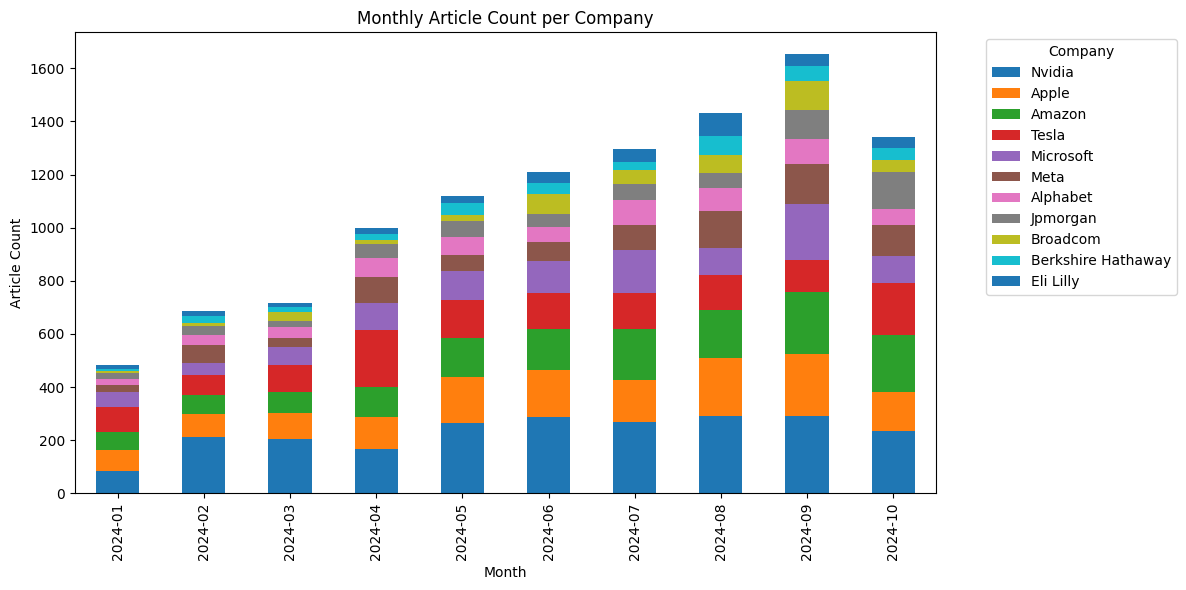

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'Date' to datetime and extract month for grouping
merged_df['Month'] = pd.to_datetime(merged_df['Date']).dt.to_period("M")
monthly_counts = merged_df.groupby(['Month', 'Company']).size().unstack()

# Sort columns based on the total counts across all months
monthly_counts = monthly_counts[monthly_counts.sum(axis=0).sort_values(ascending=False).index]

# Plot stacked bar chart
monthly_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Monthly Article Count per Company')
plt.xlabel('Month')
plt.ylabel('Article Count')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Downloading and Storing Hourly Stock Data for Selected Companies

This section retrieves hourly stock data for each company in our tickers dictionary, storing the results for analysis.

In [ ]:
# tickers is a dictionary located in utils.py
tickers = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Nvidia': 'NVDA',
    'Amazon': 'AMZN',
    'Meta': 'META',
    'Alphabet': 'GOOGL',
    # 'Alphabet_Class_C': 'GOOG',
    'Berkshire_Hathaway': 'BRK-A',
    # 'Berkshire_Hathaway_Class_B': 'BRK.B',
    'Broadcom': 'AVGO',
    'Eli_Lilly': 'LLY',
    'JPMorgan': 'JPM',
    'Tesla': 'TSLA'
}
start_date = '2024-01-01'
stock_dfs = {}
for company in tickers:
    stock_hourly_data = yf.download(tickers[company], start=start_date, end=pd.Timestamp.today(), interval='1h').reset_index()
    stock_hourly_data['Datetime'] = stock_hourly_data['Datetime'].dt.tz_convert('UTC')
    stock_dfs[company] = stock_hourly_data.copy()
    stock_hourly_data.to_csv(f'./dataframes/{company}_stock_df.csv')
# stock_dfs

### 🔗 **Next Steps**

In this project, we have meticulously analyzed financial articles to extract valuable sentiment and emotion insights. For a more interactive experience and deeper analysis, please explore our dedicated dashboard, where you can visualize trends and correlations with market movements.

You can access the dashboard [here](https://news-analysis-dashboard.onrender.com) and view the source code on GitHub [here](https://github.com/arieg88/NewsAnalysisDashboard).

Thank you for following along this journey into financial sentiment analysis!